## Modules à importer

In [4]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from sklearn.cluster import KMeans
from variaIa import baserate
from variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean, std et données totales

In [48]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

surv = {'SNF':  d_snf,
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

with open('../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)

z_max['SNF'] = [10, 10]
z_max['HST'] = [10, 10]

colors = {'SNF': 'orange',
          'SDSS': 'lime',
          'PS1': 'blue',
          'SNLS': 'red',
          'HST': 'purple'}

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()

for survey in surveys[1:]:
    zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][1])
    z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
    x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
    x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
zmax_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < z_max['SNF'][1])
z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values[zmax_cuts['SNF']]
x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values[zmax_cuts['SNF']]
x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zmax_cuts['SNF']]

datax_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((x1_zcuts['SNF'],
                             x1_zcuts['SDSS'])),
             x1_zcuts['PS1'])),
         x1_zcuts['SNLS'])),
     x1_zcuts['HST']))
                                                     
datax_err_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((x1_err_zcuts['SNF'],
                             x1_err_zcuts['SDSS'])),
             x1_err_zcuts['PS1'])),
         x1_err_zcuts['SNLS'])),
     x1_err_zcuts['HST']))
                                                     
dataz_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((z_zcuts['SNF'],
                             z_zcuts['SDSS'])),
             z_zcuts['PS1'])),
         z_zcuts['SNLS'])),
     z_zcuts['HST']))

## Number of data for each survey and total

In [4]:
for survey in surveys:
    print(r'N(' + survey + ') = ', len(z_zcuts[survey]))

print(r'N(total) = ', np.sum([len(z_zcuts[survey]) for survey in surveys]))

N(SNF) =  141
N(SDSS) =  175
N(PS1) =  126
N(SNLS) =  108
N(HST) =  26
N(total) =  576


## Utilisation de la classe _stretchevol_ pour le fit double total

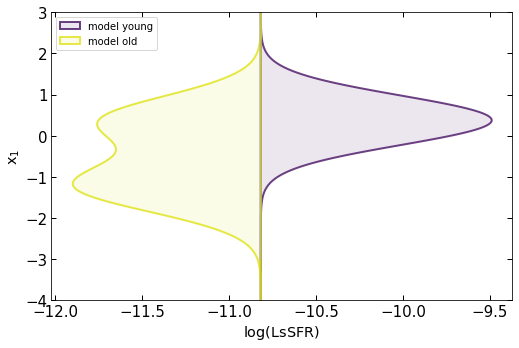

In [49]:
reload(stretchevol)

evol3G2M2S = stretchevol.Evol3G2M2S()
evol3G2M2S.set_data(dataz_all, datax_all, datax_err_all)

evol3G2M2S.GUESSVAL[3] = -1

evol3G2M2S.minimize()

evol3G2M2S.plotter()

#fig=plt.gcf()
#fig.savefig('/home/nora/Pictures/BiGaussian.pdf')

## Défnition _age-law_

In [50]:
def delta(z):
    return stretchevol.MockEvol().delta(z)

with open('../Data/SNF_results', 'rb') as f:
    res_SNF = pickle.load(f)

def age_law_snf(z):
    """Analytical law with snf results"""
    return (delta(z)*res_SNF['mu_1'] + (1-delta(z))*(res_SNF['a']*res_SNF['mu_1'] + 
                                                 (1-res_SNF['a'])*res_SNF['mu_2']))
    #return delta(z)*0.3869 + (1-delta(z))*(0.4772*0.3869 + (1-0.4772)*-1.5210)

def age_law_all(z):
    """Analytical law with 3G2M2S results"""
    return (delta(z)*evol3G2M2S.param['mu_1']
      + (1-delta(z))*(evol3G2M2S.param['a']*evol3G2M2S.param['mu_1']
              + (1 - evol3G2M2S.param['a'])*evol3G2M2S.param['mu_2']))

def age_law_gen(z, param_hesse):
    """Function to get laws with parameters taken wrt there hesse error"""
    return (delta(z)*param_hesse[1]
      + (1-delta(z))*(param_hesse[0]*param_hesse[1]
              + (1 - param_hesse[0])*param_hesse[2]))

## Définition de _cov_ pour sélection aléatoire des paramètres

In [51]:
cov = im.Minuit.matrix(evol3G2M2S.m_tot)
mean = [evol3G2M2S.m_tot.values[i] for i in range(5)]
param_hesse_mat = scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=500)

In [23]:
evol3G2M2S.m_tot.values

<ValueView of Minuit at 55abaa977050>
  a: 0.30560323851653853
  mu_1: 0.4486822697545148
  sigma_1: 0.556055252862088
  mu_2: -1.1284479755006687
  sigma_2: 0.6604506509087873

In [24]:
cov

-----------------------------------------------------
|         |       a    mu_1 sigma_1    mu_2 sigma_2 |
-----------------------------------------------------
|       a |   0.054  -0.022   0.012  -0.063  -0.029 |
|    mu_1 |  -0.022   0.011  -0.006   0.027   0.012 |
| sigma_1 |   0.012  -0.006   0.004  -0.015  -0.006 |
|    mu_2 |  -0.063   0.027  -0.015   0.083   0.036 |
| sigma_2 |  -0.029   0.012  -0.006   0.036   0.020 |
-----------------------------------------------------

### Only take _a_, _µ1_ and _µ2_

In [52]:
param_hesse_cut = param_hesse_mat[:,[0,1,3]]

### List of all the models

In [53]:
zlin = np.linspace(0, 2.65, 1000)
models_hesse = [[age_law_gen(zi, param_hesse) for zi in zlin] for param_hesse in param_hesse_cut]
models_hesse = np.asarray(models_hesse)

### Take _std_

In [54]:
models_std = np.std(models_hesse, axis=0)

## Moyennage sur toutes les données pour plus de points

### Définition des bins sur lesquels faire les moyennes

In [55]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

n, bins, patches = plt.hist(dataz_all, histedges_equalN(dataz_all, 6))
plt.close()

### Tracé des points

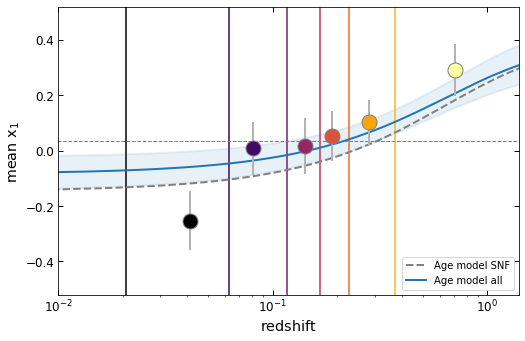

In [56]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop = dict(marker="o", ms=15, ecolor="0.7", lw=2, mew=1, mec="0.5", zorder=5)

#ax.scatter(dataz_all, datax_all, color="0.7")

cmap = 'inferno'

vmap_v = plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(bins)))
for i in range(len(bins)):
    ax.vline(bins[i], color = vmap_v[i])

slices = []
x1_comp_mean = np.zeros(6)
x1_comp_std = np.zeros(6)
z_comp_mean = np.zeros(6)
z_comp_std = np.zeros(6)

for i in range(6):
    slices.append(np.where((dataz_all > bins[i]) & (dataz_all <= bins[i+1])))
    x1_comp_mean[i] = np.mean(datax_all[slices[i]])
    x1_comp_std[i] = np.std(datax_all[slices[i]])
    z_comp_mean[i] = np.mean(dataz_all[slices[i]])
    z_comp_std[i] = np.std(dataz_all[slices[i]])
    
vmap_s = plt.cm.get_cmap(cmap)(np.linspace(0, 1, 6))
for i, c in zip(range(6), vmap_s):
   ax.errorbar(z_comp_mean[i], x1_comp_mean[i],
               xerr = z_comp_std[i]/np.sqrt(len(dataz_all[slices[i]])),
               yerr = x1_comp_std[i]/np.sqrt(len(dataz_all[slices[i]])),
               color=vmap_s[i], **prop)

#ax.plot(zz, np.mean(x1_z, axis=1),
#        color="0.5", lw=2, zorder=2, label="Age mock all")
#ax.plot(zz_all, np.mean(x1_z_all, axis=1), color="0.7", zorder=2, label="Age model all")

ax.plot(zlin, age_law_snf(zlin),
        color="0.5", lw=2, ls='--',
        label='Age model SNF')

ax.plot(zlin, age_law_all(zlin),
        color="C0", lw=2,
        label='Age model all')

ax.fill_between(zlin, age_law_all(zlin) + models_std,
                age_law_all(zlin) - models_std,
                color="C0", alpha=.1, lw=2)

ax.hline(np.mean(datax_all), color='.5', lw=1, ls='--')

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,x}_1$ ", fontsize="x-large")

ax.legend(ncol=1, loc='lower right')

#ax.set_ylim(-3, 3)
ax.set_ylim(-0.52, 0.52)
ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')

fig=plt.gcf()
fig.savefig('../../../Images/stretchevol_all_vs_snf_maglim_sup.pdf')

In [33]:
np.mean(datax_all)

-0.001531440657297817